In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.display import Image
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from skimage import io
import matplotlib.pyplot as plt
print(os.listdir("../input"))

['train', 'train.csv', 'sample_submission.csv', 'test']


In [2]:
sub_df = pd.read_csv('../input/sample_submission.csv')

In [3]:
train_dir = '../input/train/train/'
test_dir = '../input/test/test/'

In [4]:
class CactusDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        filename = os.path.join(self.root_dir,self.df.iloc[idx,0])
        label = self.df.iloc[idx,1]
        image = io.imread(filename)
        if self.transform:
            image = self.transform(image)
        return {'image': image, 'label': label, 'id': self.df.iloc[idx,0]}

In [5]:
transformation = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(30.0),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_transform =  torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
train_data = CactusDataset('../input/train.csv',train_dir,transform=transformation)

In [7]:
test_data = CactusDataset('../input/sample_submission.csv', test_dir,transform=test_transform)

In [8]:
# training - validation split
def training_validation_split(size, validation_ratio, shuffle, seed):
    indices = list(range(size))
    split = int(np.floor(validation_ratio * size))
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]
    return SubsetRandomSampler(train_indices), SubsetRandomSampler(val_indices)

In [9]:
batch_size=128
train_sampler, val_sampler = training_validation_split(len(train_data), 0.2, True, 34)
validation_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                                sampler=val_sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [10]:
def pixel_count(shape):
    return shape[0]*shape[1]*shape[2]
raw_pixel_count=pixel_count(next(iter(train_loader))['image'][0].shape)

In [11]:
# class FullyConnected(torch.nn.Module):
#     def __init__(self, in_dim, hidden_dims):
#         super(FullyConnected, self).__init__()
#         self.in_dim = in_dim
#         self.hidden_dims = hidden_dims
#         self.in_layer = torch.nn.Linear(in_dim, hidden_dims[0])
#         self.hiddens = torch.nn.ModuleList([torch.nn.Linear(hidden_dims[i-1], hidden_dims[i]) for i in range(1,len(hidden_dims))])
#         self.out_layer = torch.nn.Linear(hidden_dims[-1], 2)
#         self.soft = torch.nn.LogSoftmax(dim=1)
#     def forward(self, x):
#         x = x.view(-1,self.in_dim)
#         x = torch.relu(self.in_layer(x))
#         for l in self.hiddens:
#             x = torch.relu(l(x))
#         x = self.out_layer(x)
#         x = self.soft(x)
        
#         return x

In [12]:
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=1.0e-3,momentum=0.9)
# epochs = 10

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [14]:
# net = FullyConnected(in_dim = raw_pixel_count, hidden_dims=[128,32]).to(device=device)

In [15]:
# losses = []
# for i in range(epochs):
#     print('Running epoch {}'.format(i))
#     for t, samp in enumerate(train_loader,0):
#         image = samp['image'].to(device=device)
#         label = samp['label'].to(device=device)
#         y_pred = net(image)
#         y_true = label
#         loss = criterion(y_pred, y_true)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.item())

In [16]:
# correct=0
# total = 0
# with torch.no_grad():
#     for samp in train_loader:
#         image = samp['image'].to(device=device)
#         label = samp['label'].to(device=device)
#         y_pred = net(image)
#         y_true = label
#         pred_cat = y_pred.max(-1)[1]
#         for i in range(len(pred_cat)):
#             if pred_cat[i] == y_true[i]:
#                 correct+=1
#             total +=1
# print('{} of {} labels are correct, accuracy: {}%'.format(correct, total, correct/total*100.0))

In [17]:
from math import floor
def conv_size(input_size, padding, dilation, kernel_size, stride):
    return floor((input_size + 2*padding - dilation*(kernel_size-1)-1)/stride+1)

In [18]:
conv_size(1, 0, 1, 1, 1)

1

In [19]:
class Convolutional(torch.nn.Module):
    def __init__(self):
        super(Convolutional, self).__init__()
        self.soft = torch.nn.LogSoftmax(dim=1)
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3,
                           out_channels=32,
                           kernel_size=3,
                           padding=1), #3x32x32 -> 64 x 32 x 32
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,stride=2), # -> 64 x 16 x 16
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32,
                           out_channels=64,
                           kernel_size=3,
                           padding=1), # 64 x 16x16 -> 128 x 16x16
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,stride=2), # 128 x 8 x 8
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64,
                           out_channels=128,
                           kernel_size=3,
                           padding=1), # 128 x 8x8 -> 256 x 8x8
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,stride=2), # 256 x 4 x 4
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=128,
                           out_channels=256,
                           kernel_size=3,
                           padding=1), # 256 x 4x4 -> 512 x 4x4
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,stride=2), # 512 x 2 x 2
        )
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=256,
                           out_channels=512,
                           kernel_size=3,
                           padding=1), # 512 x 2x2 -> 1024 x 2x2
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,stride=2), # 1024 x 1 x 1
        )
        self.final1 = torch.nn.Conv2d(in_channels=512,
                                     out_channels=128,
                                     kernel_size=1,
                                     padding=0)
        self.final2 = torch.nn.Conv2d(in_channels=128,
                                     out_channels=32,
                                     kernel_size=1,
                                     padding=0)
        self.final3 = torch.nn.Conv2d(in_channels=32,
                                     out_channels=2,
                                     kernel_size=1,
                                     padding=0)
        self.dropout = torch.nn.Dropout()
    def forward(self, x):
        x = self.dropout(self.layer1(x))
        x = self.dropout(self.layer2(x))
        x = self.dropout(self.layer3(x))
        x = self.dropout(self.layer4(x))
        x = self.dropout(self.layer5(x))
        x = self.final3(self.final2(self.final1(x)))
        
        return x

In [20]:
cnn = Convolutional().to(device=device)

In [21]:
def compute_accuracy(data):
    overall = 0
    correct = 0
    #cnn.eval()
    with torch.no_grad():
        for samp in data:
            image = samp['image'].to(device=device)
            label = samp['label'].to(device=device)
            y_pred = cnn(image).view(-1,2)
            y_true = label
            tot = y_true.size(0)
            _, predicted = torch.max(y_pred.data, 1)
            cor = (predicted == y_true).sum().item()
            overall += tot
            correct += cor
    return (correct/overall)

In [22]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=1.0e-4)
epochs = 100
losses = []
train_accs = []
val_accs = []
for i in range(epochs):
    print('Running epoch {}'.format(i))
    #cnn.train()
    for t, samp in enumerate(train_loader,0):
        image = samp['image'].to(device=device)
        label = samp['label'].to(device=device)
        y_pred = cnn(image).view(-1,2)
        y_true = label
        loss = criterion(y_pred, y_true)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        total = y_true.size(0)
        _, predicted = torch.max(y_pred.data, 1)
        correct = (predicted == y_true).sum().item()
        train_accs.append(correct/total)
    val_accs.append(compute_accuracy(validation_loader))
print('Training finished')

Running epoch 0
Running epoch 1
Running epoch 2
Running epoch 3
Running epoch 4
Running epoch 5
Running epoch 6
Running epoch 7
Running epoch 8
Running epoch 9
Running epoch 10
Running epoch 11
Running epoch 12
Running epoch 13
Running epoch 14
Running epoch 15
Running epoch 16
Running epoch 17
Running epoch 18
Running epoch 19
Running epoch 20
Running epoch 21
Running epoch 22
Running epoch 23
Running epoch 24
Running epoch 25
Running epoch 26
Running epoch 27
Running epoch 28
Running epoch 29
Running epoch 30
Running epoch 31
Running epoch 32
Running epoch 33
Running epoch 34
Running epoch 35
Running epoch 36
Running epoch 37
Running epoch 38
Running epoch 39
Running epoch 40
Running epoch 41
Running epoch 42
Running epoch 43
Running epoch 44
Running epoch 45
Running epoch 46
Running epoch 47
Running epoch 48
Running epoch 49
Running epoch 50
Running epoch 51
Running epoch 52
Running epoch 53
Running epoch 54
Running epoch 55
Running epoch 56
Running epoch 57
Running epoch 58
Running

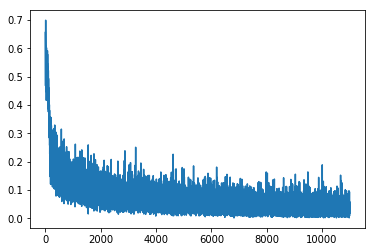

In [23]:
plt.plot(losses)

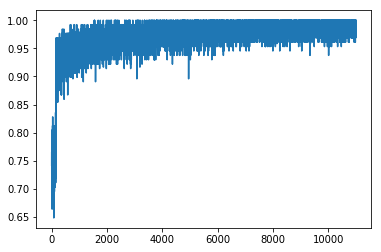

In [24]:
plt.plot(train_accs)

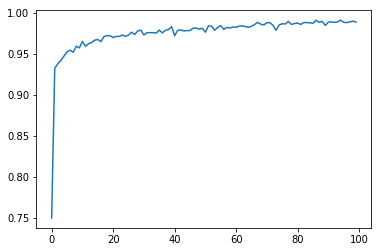

In [25]:
plt.plot(val_accs)

In [26]:
cnn.eval()
with torch.no_grad():
    for sample in test_loader:
        image = sample['image'].to(device=device)
        y_pred = cnn(image).view(-1,2)
        probs = torch.nn.functional.softmax(y_pred,dim=1)
        has_cactus = probs[:,1]
        for i in range(len(image)):
            sub_df.loc[sub_df['id']==sample['id'][i],'has_cactus'] = has_cactus[i].item()

In [27]:
sub_df.to_csv('submission.csv',index=False)